In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
from sqlalchemy import inspect

inspector = inspect(engine)
# Get the table names
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Get a list of columns names and their datatypes for the measurement table
ms = inspector.get_columns('measurement')

for i in ms:
    print(i['name'], i["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Get a list of columns names and their datatypes for the station table
st = inspector.get_columns('station')

for i in st:
    print(i['name'], i["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

# Exploratory Climate Analysis

### Precipitation Analysis

- Design a query to retrieve the last 12 months of precipitation data.

- Select only the `date` and `prcp` values.

- Load the query results into a Pandas DataFrame and set the index to the date column.

- Sort the DataFrame values by `date`.

- Plot the results using the DataFrame `plot` method.

- Use Pandas to print the summary statistics for the precipitation data.

In [14]:
# Get the latest date from the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
# Convert the latest date into readable string
latest_date_str = dt.datetime.strptime(latest_date,"%Y-%m-%d")
# Get the date one year ago from the latest date
one_year_ago = latest_date_str - dt.timedelta(days=365)
# Convert the date into string format date
one_year_ago_str = one_year_ago.strftime("%Y-%m-%d")

In [15]:
# Perform a query to retrieve the data and precipitation scores for the last year
prcp_for_one_year = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=one_year_ago_str).all()
prcp_for_one_year[:10]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0)]

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
date_prcp_df = pd.DataFrame(prcp_for_one_year,columns=['date','precipitation'])
idx_date_prcp_df = date_prcp_df.set_index('date')
idx_date_prcp_df

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [17]:
# Clean up data by dropping NaN
idx_date_prcp_df = idx_date_prcp_df.dropna(how='any')
# Sort the dataframe by date
idx_date_prcp_df = idx_date_prcp_df.sort_index(ascending = True)
idx_date_prcp_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


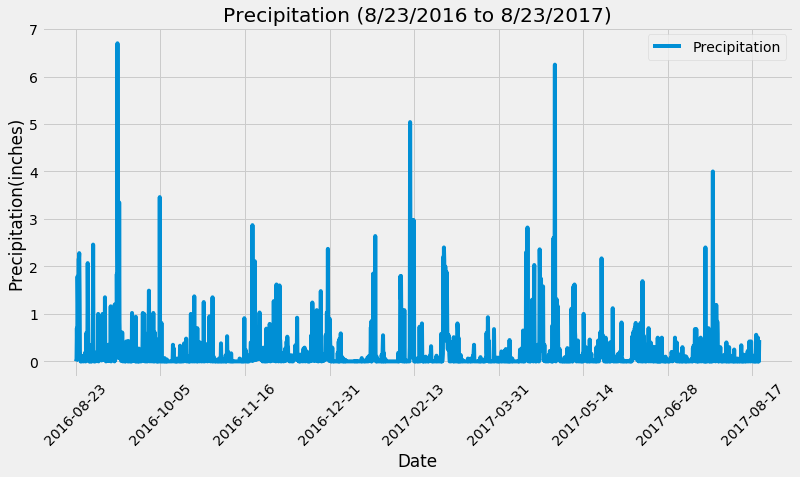

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
idx_date_prcp_df.plot(figsize=(12,6))
plt.xlabel("Date")
plt.ylabel("Precipitation(inches)")
plt.title("Precipitation (8/23/2016 to 8/23/2017)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
idx_date_prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

- Design a query to calculate the total number of stations.

- Design a query to find the most active stations.

  - List the stations and observation counts in descending order.

  - Which station has the highest number of observations?

  - Hint: You may need to use functions such as `func.min`, `func.max`, `func.avg`, and `func.count` in your queries.

- Design a query to retrieve the last 12 months of temperature observation data (TOBS).

  - Filter by the station with the highest number of observations.

  - Plot the results as a histogram with `bins=12`.

In [20]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()[0][0]

9

In [21]:
# Design a query to show how many stations are available in this dataset?
# Count the distinct stations from the measurement data
from sqlalchemy import distinct
number_of_stations = session.query(func.count(distinct(Measurement.station))).all()[0][0]

print(f"Total Number of Stations: {number_of_stations}")

Total Number of Stations: 9


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Which station has the highest number of observations?
most_active_station = session.query(Measurement.station).group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).first()[0]

most_active_station

'USC00519281'

In [39]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_stat = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]

most_active_station_stat = session.query(*temp_stat).filter(Measurement.station==most_active_station).all()

print(f"The lowest temperature recorded for station 'USC00519281' is {most_active_station_stat[0][0]}")
print(f"The highest temperature recorded for station 'USC00519281' is {most_active_station_stat[0][1]}")
print(f"The average temperature for station 'USC00519281' is {most_active_station_stat[0][2]}")

The lowest temperature recorded for station 'USC00519281' is 54.0
The highest temperature recorded for station 'USC00519281' is 85.0
The average temperature for station 'USC00519281' is 71.66378066378067


In [25]:
station_with_highest_tobs = session.query(Measurement.station).group_by(Measurement.station).\
                        order_by(func.count(Measurement.tobs).desc()).first()[0]
station_with_highest_tobs

'USC00519281'

Text(0.5, 0, 'Temperature(F)')

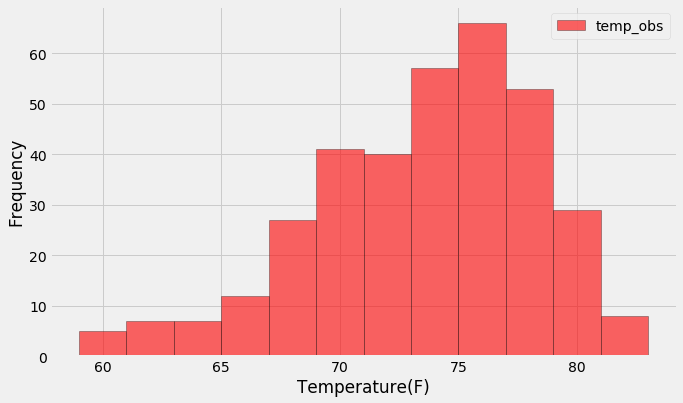

In [41]:
# Choose the station with the highest number of temperature observations.
station_with_highest_tobs = session.query(Measurement.station).group_by(Measurement.station).\
                        order_by(func.count(Measurement.tobs).desc()).first()[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query the temperature observations for the last 12 months
tobs_one_year = session.query(Measurement.date,Measurement.tobs).\
filter(Measurement.station==station_with_highest_tobs).\
filter(Measurement.date>='2016-08-23').all()

# Save the query results as Pandas DataFrame
tobs_one_year_df = pd.DataFrame(tobs_one_year,columns=['date','temp_obs'])

# Plot the histogram
tobs_one_year_df.plot.hist('temp_obs', bins=12,facecolor="red",edgecolor="black", alpha=0.6, figsize=(10,6))
plt.xlabel('Temperature(F)')

# Bonus Challenge Assignment

### Temperature Analysis I

- Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

- You may either use SQLAlchemy or pandas's `read_csv()` to perform this portion.

- Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

- Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [27]:
# Calculate the average temperature for June and December
june_tobs_mean = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m",Measurement.date)=="06").all()[0][0]
dec_tobs_mean = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m",Measurement.date)=="12").all()[0][0]

print(f"The average temperature in June is {round(june_tobs_mean,2)}")
print(f"The average temperature in December is {round(dec_tobs_mean,2)}")

The average temperature in June is 74.94
The average temperature in December is 71.04


In [28]:
# Calculate the average temperature for June and December for each stations in Hawaii
june_tobs_mean_by_station = session.query(Station.station, func.avg(Measurement.tobs)).\
                            filter(func.strftime("%m",Measurement.date)=="06").\
                            group_by(Station.station).filter(Measurement.station==Station.station).all()
dec_tobs_mean_by_station = session.query(Station.station, func.avg(Measurement.tobs)).\
                            filter(func.strftime("%m",Measurement.date)=="12").\
                            group_by(Station.station).filter(Measurement.station==Station.station).all()

print(f"Average temperature in June for each station: ")
print(*june_tobs_mean_by_station, sep = "\n")
print("------------------------------------------------")
print(f"Average temperature in Decemember for each station: ")
print(*dec_tobs_mean_by_station, sep = "\n")

Average temperature in June for each station: 
('USC00511918', 74.13939393939394)
('USC00513117', 74.05084745762711)
('USC00514830', 76.00537634408602)
('USC00516128', 71.9372197309417)
('USC00517948', 76.6554054054054)
('USC00518838', 73.39473684210526)
('USC00519281', 73.27118644067797)
('USC00519397', 77.55932203389831)
('USC00519523', 76.66810344827586)
------------------------------------------------
Average temperature in Decemember for each station: 
('USC00511918', 69.6842105263158)
('USC00513117', 71.06944444444444)
('USC00514830', 73.2247191011236)
('USC00516128', 69.29126213592232)
('USC00517948', 71.8348623853211)
('USC00518838', 72.42105263157895)
('USC00519281', 69.90322580645162)
('USC00519397', 71.10952380952381)
('USC00519523', 72.43333333333334)


In [29]:
# Query the temperature data for the two months and assign the values to corresponding variables
june_tobs = session.query(Measurement.tobs).filter(func.strftime("%m",Measurement.date)=="06").all()
dec_tobs = session.query(Measurement.tobs).filter(func.strftime("%m",Measurement.date)=="12").all()

# Perform the unpaired t-test to compare means of the two months
# Paired t-test cannot be used since the sample sizes differ
stats.ttest_ind(june_tobs,dec_tobs)

Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))

In [30]:
print(f"June sample size: {len(june_tobs)}")
print(f"December sample size: {len(dec_tobs)}")

June sample size: 1700
December sample size: 1517


### Temperature Analysis II

- The starter notebook contains a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d`. The function will return the minimum, average, and maximum temperatures for that range of dates.

- Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

- Plot the min, avg, and max temperature from your previous query as a bar chart.

  - Use the average temperature as the bar height.

  - Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tstats = calc_temps('2017-08-01','2017-08-07')

tmin,tavg,tmax = [x for x in tstats[0]]
print(f"Minimum temperature is {tmin}")
print(f"Average temperature is {tavg}")
print(f"Maximum temperature is {tmax}")

Minimum temperature is 72.0
Average temperature is 79.25
Maximum temperature is 83.0


Text(0, 0.5, 'Temp F')

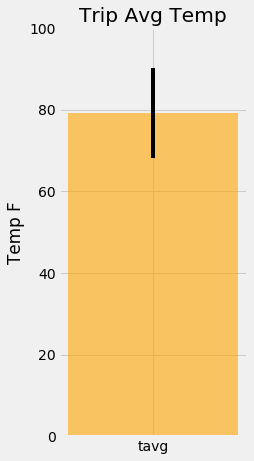

In [33]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig,ax = plt.subplots(figsize=(3,7))
ax.bar('tavg',tavg,width=0.01,yerr=(tmax-tmin),color="orange",alpha=0.6)
ax.set_ylim(0,100)
ax.set_title("Trip Avg Temp")
ax.set_ylabel("Temp F")

### Daily Rainfall Average

- Calculate the rainfall per weather station using the previous year's matching dates.

- Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.

- You are provided with a function called `daily_normals` that will calculate the daily normals for a specific date. This date string will be in the format `%m-%d`. Be sure to use all historic TOBS that match that date string.

- Create a list of dates for your trip in the format `%m-%d`. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.

- Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

- Use Pandas to plot an area plot (`stacked=False`) for the daily normals.

In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel=[Measurement.station, Station.name, func.sum(Measurement.prcp),\
     Station.latitude, Station.longitude, Station.elevation]

rainfall_per_station = session.query(*sel).filter(Measurement.station==Station.station).\
                        group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

rainfall_per_station


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  1068.0899999999956,
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  588.6399999999976,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  382.61999999999847,
  21.4234,
  -157.8015,
  14.6),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  295.67999999999944,
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  234.49000000000026,
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  131.62000000000063,
  21.2716,
  -157.8168,
  3.0),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  92.68000000000006,
  21.3152,
  -157.9992,
  0.9),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  70.87000000000005,
  21.4992,
  -158.0111,
  306.6),
 ('USC00517948',
  'PEARL CITY, HI US',
  43.44000000000002,
  21.3934,
  -157.9751,
  11.9)]

In [35]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2020-08-01'
end_date = '2020-08-07'

# Use the start and end date to create a range of dates
date_range = pd.date_range(start=start_date,end=end_date)

# Stip off the year and save a list of %m-%d strings
date_list = []
for date in date_range:
    month_date = date.strftime("%m-%d")
    date_list.append(month_date)


# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in date_list:
    normals.append(daily_normals(date)[0])
    
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [37]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normal_df = pd.DataFrame(normals,columns=['tmin','tavg','tmax'])
daily_normal_df['date'] = date_list

#Set the index
daily_normal_df = daily_normal_df.set_index('date')
daily_normal_df

,tmin,tavg,tmax
date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


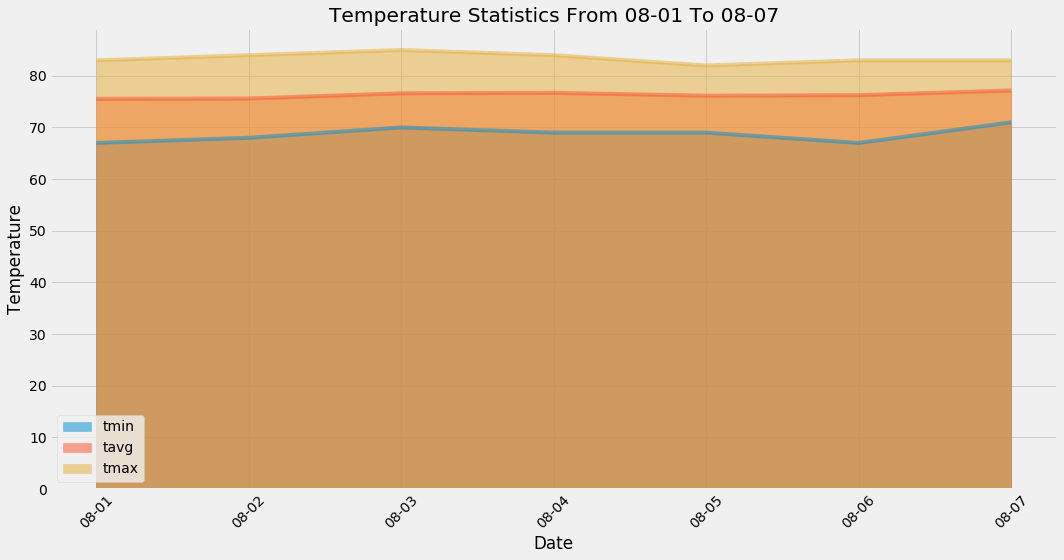

In [38]:
# Plot the daily normals as an area plot with `stacked=False` ,xticks=date_list
daily_normal_df.plot.area(stacked=False, use_index=True,rot=45,figsize=(15,8))
plt.title("Temperature Statistics From 08-01 To 08-07")
plt.xlabel("Date")
plt.ylabel('Temperature')
plt.tight_layout()
plt.show()